In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define the Poisson equation
def poisson_equation(x, y):
    return 2 * x + 2 * y

# Define the exact solution of the Poisson equation
def exact_solution(x, y):
    return (1/3) * (x**3 + y**3)

# Generate random points within the domain
def generate_random_points(num_points):
    x_rand = np.random.uniform(0, 1, (num_points, 1))
    y_rand = np.random.uniform(0, 1, (num_points, 1))
    return x_rand, y_rand

In [ ]:
# Define the Physics-Informed Neural Network (PINN) model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        # Define the dense layers
        self.dense1 = tf.keras.layers.Dense(40, activation='tanh', input_shape=(2,))
        self.dropout1 = tf.keras.layers.Dropout(0.2)
        self.dense2 = tf.keras.layers.Dense(40, activation='tanh')
        self.dropout2 = tf.keras.layers.Dropout(0.2)
        self.dense3 = tf.keras.layers.Dense(1, activation=None)

    # Define the forward pass
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        return self.dense3(x)

    # Calculate the Laplacian of the predicted solution
    def laplacian(self, u, x, y):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            tape.watch(y)
            inputs = tf.concat([x, y], axis=1)
            u = self(inputs)
            gradients = tape.gradient(u, [x, y])
            laplacian_u_x = tape.gradient(gradients[0], x)
            laplacian_u_y = tape.gradient(gradients[1], y)

        laplacian_u = laplacian_u_x[:, 0] + laplacian_u_y[:, 0]
        return laplacian_u

In [ ]:
# Define the loss function
def loss(model, x, y, pde_coeff=1.0, boundary_coeff=1.0):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(y)
        inputs = tf.concat([x, y], axis=1)
        predicted_solution = model(inputs)
        poisson_residual = model.laplacian(predicted_solution, x, y) - poisson_equation(x, y)

    boundary_residual = predicted_solution - exact_solution(x, y)

    mse_pde_residual = tf.reduce_mean(tf.square(poisson_residual))
    mse_boundary_residual = tf.reduce_mean(tf.square(boundary_residual))

    weighted_pde_residual = pde_coeff * mse_pde_residual
    weighted_boundary_residual = boundary_coeff * mse_boundary_residual

    loss_val = weighted_pde_residual + weighted_boundary_residual

    return loss_val

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
# Set the number of training points
num_points = 2000
# Generate random training points
x_train = np.random.uniform(0, 1, (num_points, 1))
y_train = np.random.uniform(0, 1, (num_points, 1))

# Convert training data to TensorFlow tensors
x_train_tf = tf.constant(x_train, dtype=tf.float32)
y_train_tf = tf.constant(y_train, dtype=tf.float32)

In [ ]:
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
loss_history = []
max_accuracy = 0
epochs = 2001
max_norms = []
l2_norms = []

In [ ]:
for epoch in range(epochs):
    # Add additional random points every 100 epochs
    if epoch % 100 == 0:
        additional_points = 200
        x_rand, y_rand = generate_random_points(additional_points)
        x_train_tf = tf.concat([x_train_tf, tf.constant(x_rand, dtype=tf.float32)], axis=0)
        y_train_tf = tf.concat([y_train_tf, tf.constant(y_rand, dtype=tf.float32)], axis=0)

    with tf.GradientTape() as tape:
        pde_coefficient = 1
        boundary_coefficient = 1

        loss_value = loss(model, x_train_tf, y_train_tf, pde_coeff=pde_coefficient, boundary_coeff=boundary_coefficient)

    grads = tape.gradient(loss_value, model.trainable_variables)

    # Calculate and store the maximum norm of the gradients
    max_grad_norm = max([tf.norm(grad) for grad in grads])
    max_norms.append(max_grad_norm)

    # Calculate and store the L2 norm of the gradients
    l2_grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(tf.square(grad)) for grad in grads]))
    l2_norms.append(l2_grad_norm)

    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    loss_history.append(loss_value.numpy())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}, Max Norm: {max_grad_norm.numpy()}, L2 Norm: {l2_grad_norm.numpy()}")

Epoch 0, Loss: 4.585265636444092, Max Norm: 4.011741638183594, L2 Norm: 5.368319988250732
Epoch 100, Loss: 0.8216082453727722, Max Norm: 0.15713462233543396, L2 Norm: 0.2623491585254669
Epoch 200, Loss: 0.7723909616470337, Max Norm: 0.07285027205944061, L2 Norm: 0.12683449685573578
Epoch 300, Loss: 0.740929901599884, Max Norm: 0.05875483155250549, L2 Norm: 0.1035851314663887
Epoch 400, Loss: 0.7145429849624634, Max Norm: 0.04611895605921745, L2 Norm: 0.08672087639570236
Epoch 500, Loss: 0.6932142376899719, Max Norm: 0.035828813910484314, L2 Norm: 0.06429105997085571
Epoch 600, Loss: 0.6812488436698914, Max Norm: 0.022543197497725487, L2 Norm: 0.036026597023010254
Epoch 700, Loss: 0.6850666403770447, Max Norm: 0.013627619482576847, L2 Norm: 0.021345684304833412
Epoch 800, Loss: 0.6812158226966858, Max Norm: 0.02668028324842453, L2 Norm: 0.042650435119867325
Epoch 900, Loss: 0.6820423007011414, Max Norm: 0.02665707655251026, L2 Norm: 0.04205053672194481
Epoch 1000, Loss: 0.67846763134002

In [ ]:
# Generate test points for visualization
x_test = np.linspace(0, 1, 100)
y_test = np.linspace(0, 1, 100)
x_test, y_test = np.meshgrid(x_test, y_test)
x_test = x_test.flatten().reshape(-1, 1)
y_test = y_test.flatten().reshape(-1, 1)
inputs_test = tf.constant(np.concatenate([x_test, y_test], axis=1), dtype=tf.float32)

predicted_solution = model(inputs_test).numpy().reshape(100, 100)

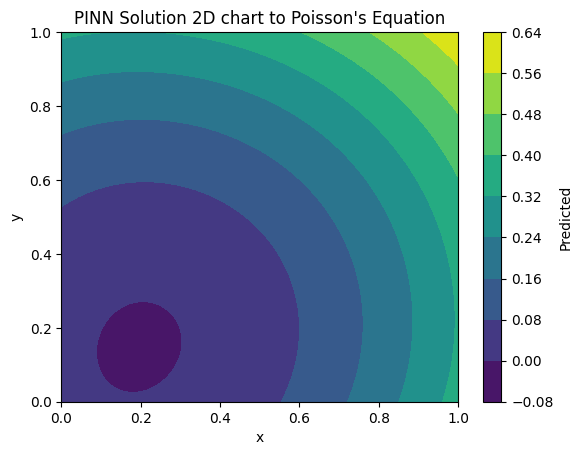

In [ ]:
plt.contourf(x_test.reshape(100, 100), y_test.reshape(100, 100), predicted_solution, cmap='viridis')
plt.colorbar(label='Predicted')
plt.title('PINN Solution 2D chart to Poisson\'s Equation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Text(0.5, 0, 'Predicted Solution')

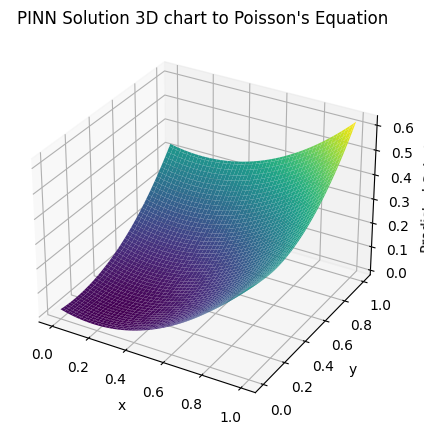

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x_test.reshape(100, 100), y_test.reshape(100, 100), predicted_solution, cmap='viridis')
ax1.set_title('PINN Solution 3D chart to Poisson\'s Equation')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('Predicted Solution')

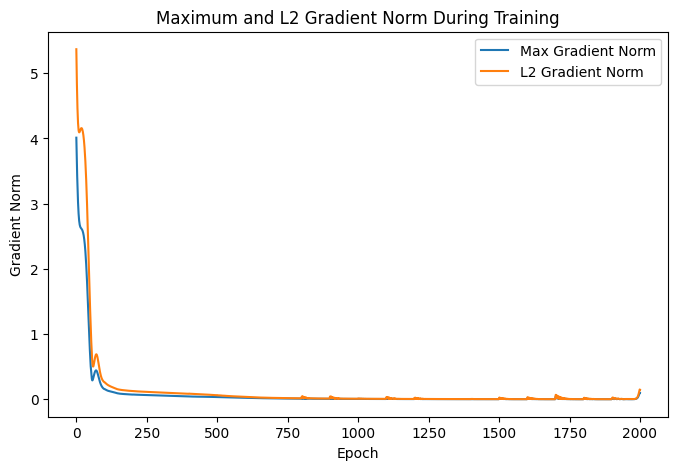

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(max_norms, label='Max Gradient Norm')
plt.plot(l2_norms, label='L2 Gradient Norm')
plt.title('Maximum and L2 Gradient Norm During Training')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()

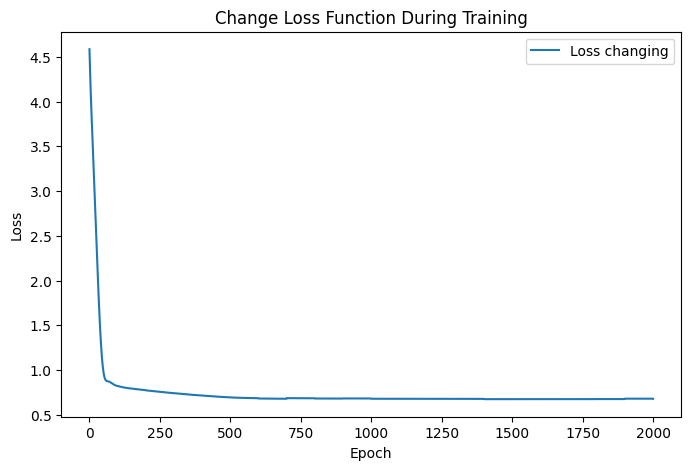

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Loss changing')
plt.title('Change Loss Function During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()